# Visualization

## Imports
The following imports are needed extract and transform data to plot metrics and make analysis.

* pandas: used for creating dataframes
* numpy: used for doing aritmetic calculations like averages
* matplotlib.pyplot: used for creating plots
* re: pyhtong library for regex, used for finding matches in strings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # python regex library

## Upload File

In [3]:
from google.colab import files

csv = files.upload()

Saving Datos.csv to Datos.csv


## Load CSV


In [4]:
dataframe = pd.read_csv("Datos.csv")
len(dataframe) # print number of rows

9595

## Transformations
I will try to discard the least amount of rows with the following transformations

### Empty Ratings
They will be assigned 0, in some analysis they will be discarded but keeping them lets us include the rest of the information in other columns of the rows with not rating


In [5]:
dataframe["Rating"] = pd.to_numeric(dataframe["Rating"].fillna(0.0))

## Duration
I use regex to find time unit matches. Priority to find string matches, from more priority to less priority, will be month, week, hour and minutes, minutes.

* We will transform everything to hours. Months has an average of 4.33 weeks, we will use this info to calcualte the total hours. Minutes will be given in their hour fraction, for example 15 minutes is 0.25 hours
* For debugging purposes I will return a tupple which will have the total ammount of hours and the greatest unit of time we used to calculate hours
* Empty strings will be [0.0 "hour"]
* Strings that don't match our regular expressions will be declared as [0.0, "noFormat"]

In [6]:
def parse_duration(text):
    if not isinstance(text, str) or not text.strip():
        return (0.0, "hour")

    text = text.lower()

    # Check for months first
    month_match = re.search(r'(\d+)\s*month', text)
    months = None
    if month_match:
        months = float(month_match.group(1))

    # Check for hours and minutes
    hour_match = re.search(r'(\d+)\s*hour', text)
    hours = None
    if hour_match:
        hours = int(hour_match.group(1))

    if months and hours:
        total_weeks = months * 4.33 # months have an average of 4.33 weeks
        total_hours = total_weeks * hours # courses that last months will how detail many hours a week are expected to study
        return(total_hours, "month")

    week_match = re.search(r'(\d+)\s*week', text)
    weeks = None
    if week_match:
        weeks = float(week_match.group(1))

        if hours:
            total_days = weeks * 7
            total_hours = total_days * hours # courses that last weeks will detail how many hours a week is needed
            return(total_hours, "week")

    minute_match = re.search(r'(\d+)\s*minute', text)
    minutes = None

    if minute_match:
        minutes = int(minute_match.group(1))

    # case when there is no hours just minuts
    if not hours and isinstance(minutes, int) and minutes > 0:
        hour_fraction = minutes / 60
        return (hour_fraction, 'minute')

    # Apply rounding rules based on minutes
    # if minutes == 0:
    #     amount = float(hours)
    # elif minutes <= 30:
    #     amount = float(hours) + 0.5
    # else:
    #     amount = float(hours + 1)

    # If no valid time info found
    if not hours and not minutes:
        return (0.0, "noFormat")

    hour_fraction = minutes / 60 if minutes else 0.0
    hours = hours + hour_fraction
    return (hours, 'hour')

dataframe[['ammountOfHours', 'courseLengthBaseUnit']] = dataframe['Duration'].apply(lambda x: pd.Series(parse_duration(x)))

dataframe.loc[(dataframe['ammountOfHours'] == 0.0) & (dataframe['courseLengthBaseUnit'] == "hour")].head()

,Course Title,Rating,Level,Duration,Schedule,Review,What you will learn,Skill gain,Modules,Instructor,Offered By,Keyword,Course Url,ammountOfHours,courseLengthBaseUnit
16,Create your UX portfolio with Adobe Portfolio,0.0,Beginner level,NaN,NaN,NaN,In this project you will learn how to create a...,"['Share Content', 'Search Engine Optimization ...",['Learn step-by-step'],['Nicole Alvelo'],['Coursera Project Network'],Arts and Humanities,https://www.coursera.org/projects/create-your-...,0.0,hour
235,Adobe Photoshop Para Principiantes: Efectos y ...,0.0,Beginner level,NaN,NaN,NaN,Aplica filtros inteligentes a una imagen.Incor...,"['Adobe Photoshop', 'Photography', 'Photo Enha...",['Learn step-by-step'],['Kevin Rodriguez'],['Coursera Project Network'],Arts and Humanities,https://www.coursera.org/projects/adobe-photos...,0.0,hour
398,Cómo crear historias para Instagram y Facebook...,4.2,Beginner level,NaN,NaN,18 reviews,En este proyecto aprenderás a utilizar Canva p...,"['Social Media Marketing', 'Social Media', 'Co...",['Learn step-by-step'],['Monica I. Heredia Rodriguez'],['Coursera Project Network'],Arts and Humanities,https://www.coursera.org/projects/como-crear-h...,0.0,hour
447,Edita tus fotos para las redes sociales con Easil,0.0,Beginner level,NaN,NaN,NaN,Crea un proyecto fotográfico individual en Eas...,"['Social Media Marketing', 'Photography', 'Soc...",['Learn step-by-step'],['Michelle Flores'],['Coursera Project Network'],Arts and Humanities,https://www.coursera.org/projects/edita-fotos-...,0.0,hour
448,Bearbeite deine Fotos für soziale Medien mit E...,0.0,Beginner level,NaN,NaN,NaN,Designe dein individuelles Fotoprojekt für soz...,"['Social Media Marketing', 'Photography', 'Gra...",['Learn step-by-step'],['Michelle Flores'],['Coursera Project Network'],Arts and Humanities,https://www.coursera.org/projects/bearbeite-fo...,0.0,hour


### Level
* I will remove the redundant word "level" for readability purposes
* The string will be lowercase
* Empty values will be replaced with "not_defined"

In [7]:
dataframe['Level'] = (
    dataframe['Level']
    .fillna('')                             # Handle None values
    .str.lower()                            # Convert to lowercase
    .str.replace('level', '', regex=False) # Remove the word 'level'
    .str.strip()                            # Remove leading/trailing spaces
    .replace('', 'not_defined')            # Replace empty strings with default
)

dataframe.loc[pd.isna(dataframe["Level"])].head() # should print no values

,Course Title,Rating,Level,Duration,Schedule,Review,What you will learn,Skill gain,Modules,Instructor,Offered By,Keyword,Course Url,ammountOfHours,courseLengthBaseUnit


### Reviews
* Will be transformed to a numeric value using regex

In [8]:
dataframe["Review"] = (
    dataframe["Review"]
    .fillna('0')
    .str.extract(r'([\d,]+)')[0]                     # Extract digits with commas
    .str.replace(',', '', regex=False)
    .fillna('0')
    .astype(int)
)

dataframe.loc[pd.isna(dataframe["Review"])] # should print no values

,Course Title,Rating,Level,Duration,Schedule,Review,What you will learn,Skill gain,Modules,Instructor,Offered By,Keyword,Course Url,ammountOfHours,courseLengthBaseUnit


### Schedule
* Column will be Renamed to "SchedFlexibility" for comprehensibility purposes
* Value will be "true" or "false" boolean values

In [9]:
dataframe["Schedule"] = dataframe['Schedule'].apply(
    lambda x: isinstance(x, str) and 'flexible' in x.lower()
)

dataframe.rename(columns={'Schedule': 'SchedFlexibility'}, inplace = True)


### Cleaning
Removing duplicates is simple since we should not have any NaN(numpy) values any more

In [10]:
unique_entries = dataframe.drop_duplicates()

## Bar Plot
Quantity of courses by "Level" bar plot. We can appreciatte that there is a good ammount of courses without a designated level

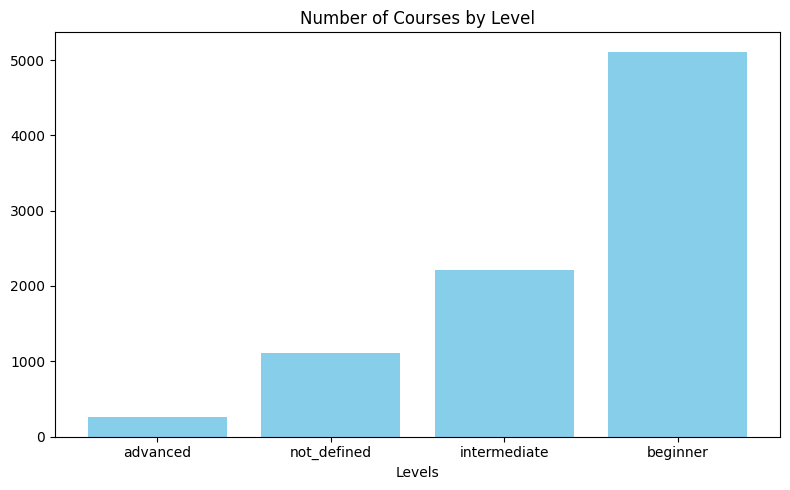

In [11]:
# count how many unique course titles exist per level
course_count_by_level = unique_entries.groupby('Level').size().reset_index(name='Course Count')

course_count_by_level = course_count_by_level.sort_values('Course Count', ascending=True)

plt.figure(figsize=(8, 5))
plt.bar(course_count_by_level['Level'], course_count_by_level['Course Count'], color='skyblue')
plt.xlabel('Levels')
plt.title('Number of Courses by Level')
plt.tight_layout()
plt.show()



## Horizontal Bar Plot
Quantity of courses by "Keyword"(category) bar plot

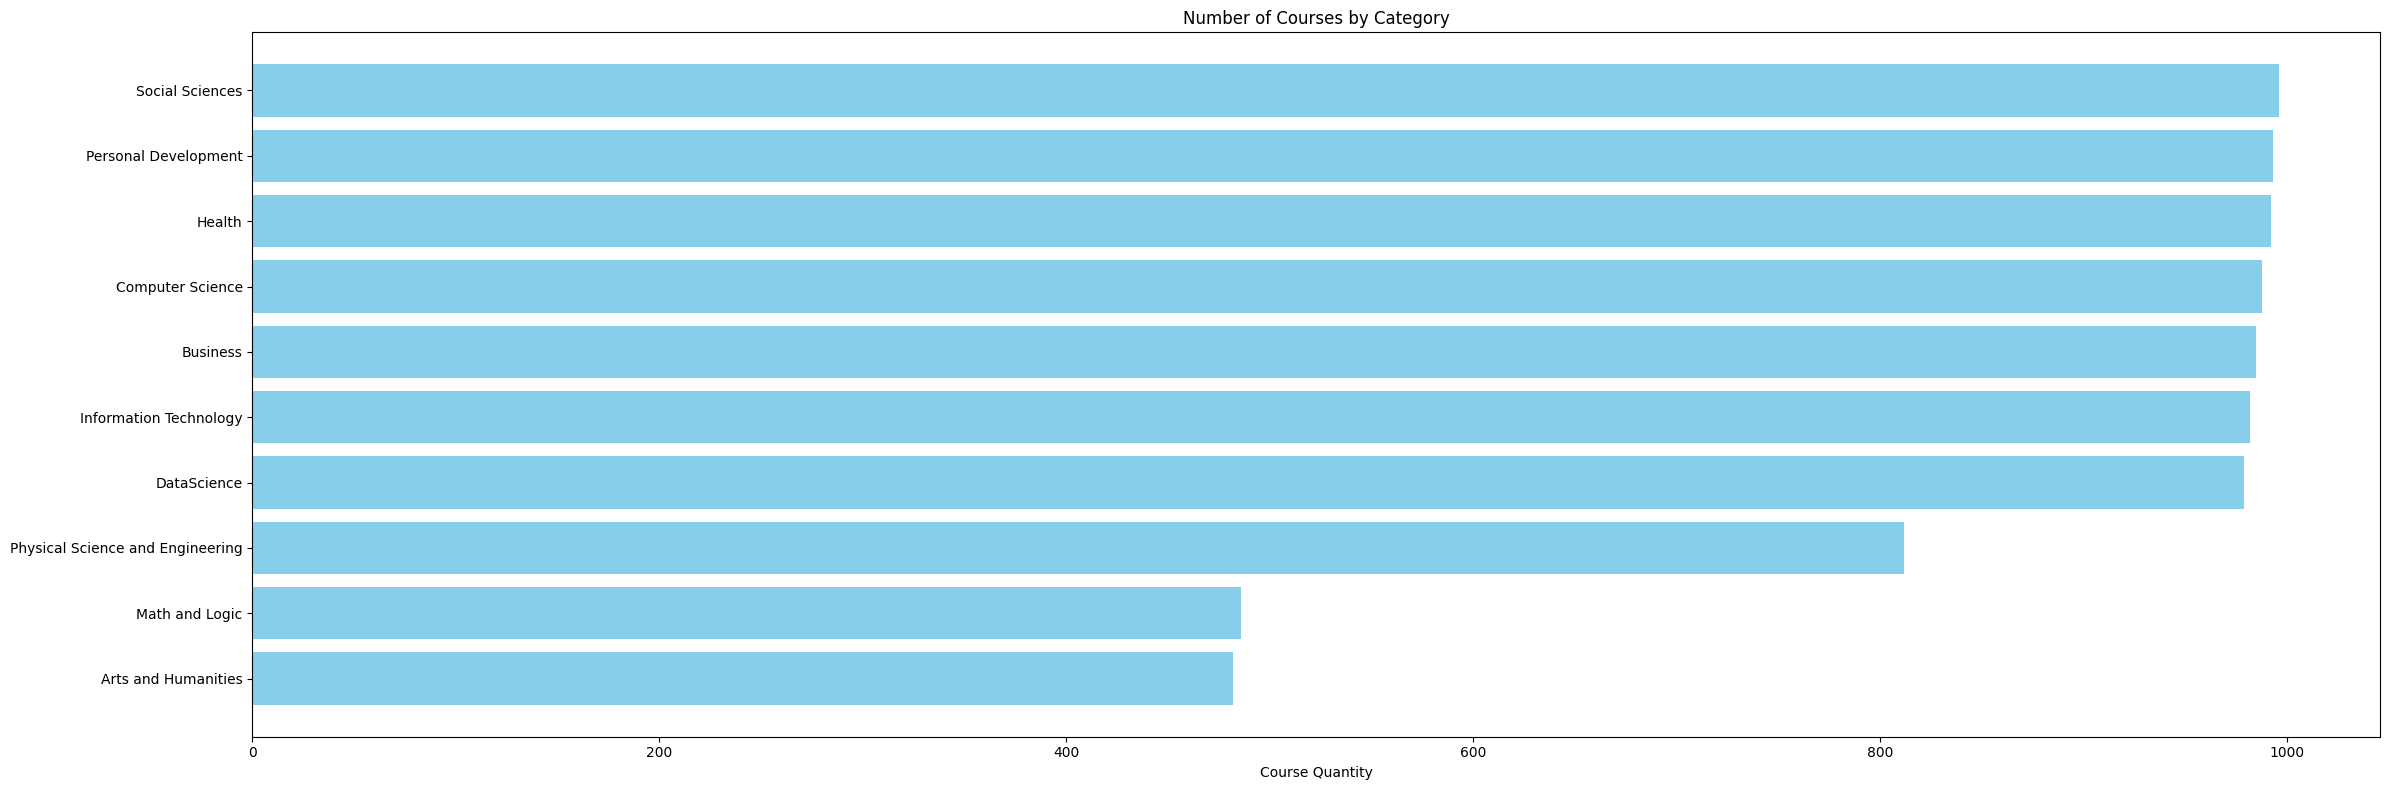

In [12]:
# Count how many unique courses in each categories exist
course_count_by_category = unique_entries.groupby('Keyword').size().reset_index(name='Course Count')

course_count_by_category = course_count_by_category.sort_values('Course Count', ascending=True)

plt.figure(figsize=(24, 8))
plt.barh(course_count_by_category['Keyword'], course_count_by_category['Course Count'], color='skyblue')
plt.xlabel('Course Quantity')
plt.title('Number of Courses by Category')
plt.tight_layout()
plt.show()

## Scatter Bar Plot(dispercion)
Shows the relationship between the course duration and the number of reviews

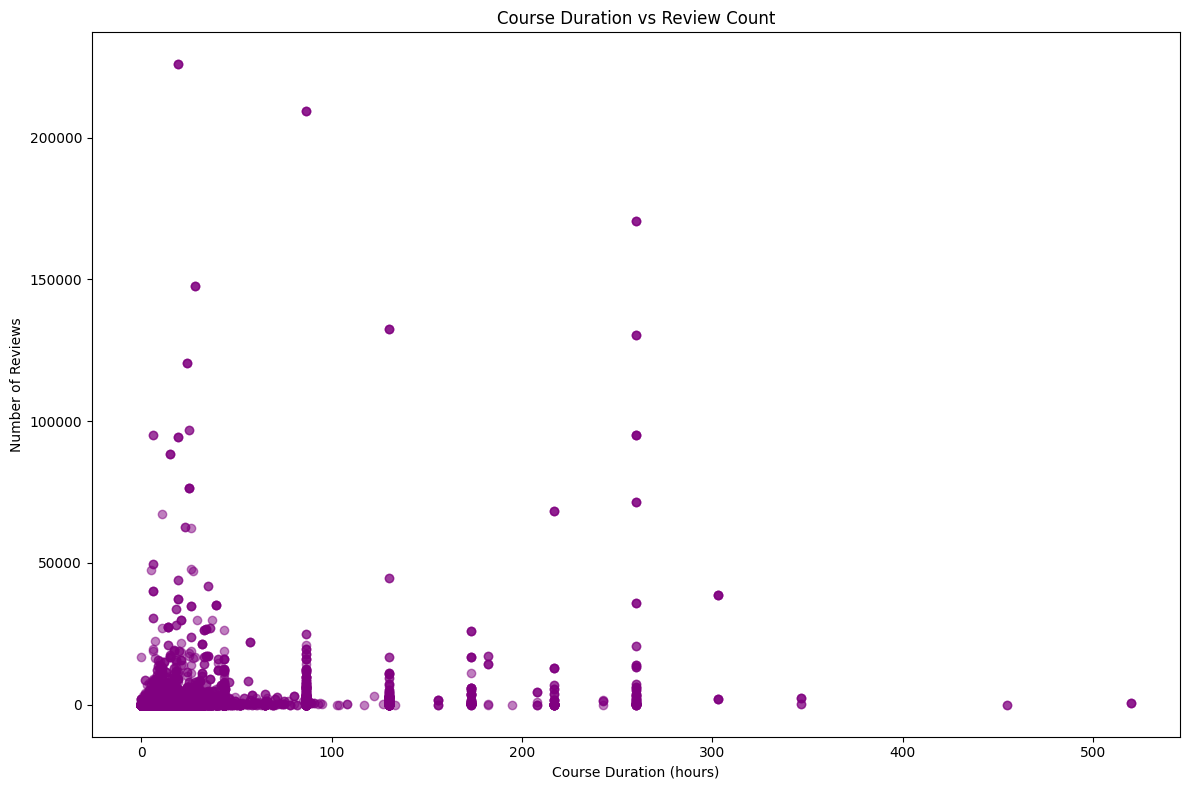

In [13]:
plt.figure(figsize=(12, 8))
plt.scatter(x= unique_entries['ammountOfHours'], y= unique_entries['Review'], alpha=0.5, color='purple')
plt.xlabel('Course Duration (hours)')
plt.ylabel('Number of Reviews')
plt.title('Course Duration vs Review Count')
plt.tight_layout()
plt.show()



## Histogram Plot(Histograma)
Shows distribution of the courses duration(time ammount in hours), this shows that there is more courses that last a few hours, there is more than 4,000 courses that last maybe less than 5 or 8 hours

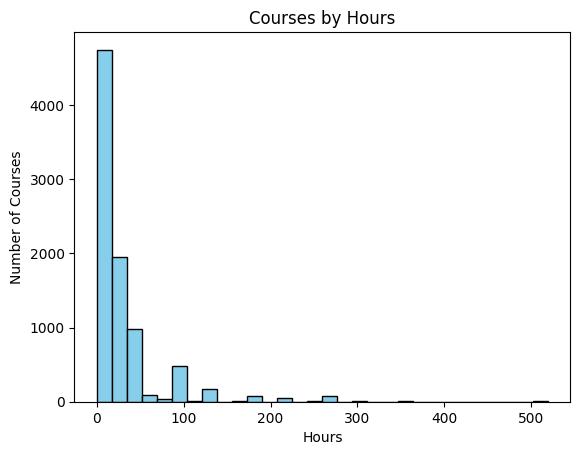

In [14]:
data = unique_entries['ammountOfHours']

plt.hist(data, bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Hours')
plt.ylabel('Number of Courses')
plt.title('Courses by Hours')

# Display the plot
plt.show()

## Boxplot Plot
Plot by "Level", here we can se the median of rating in each level and also the highest and the lowest values

<Figure size 1200x800 with 0 Axes>

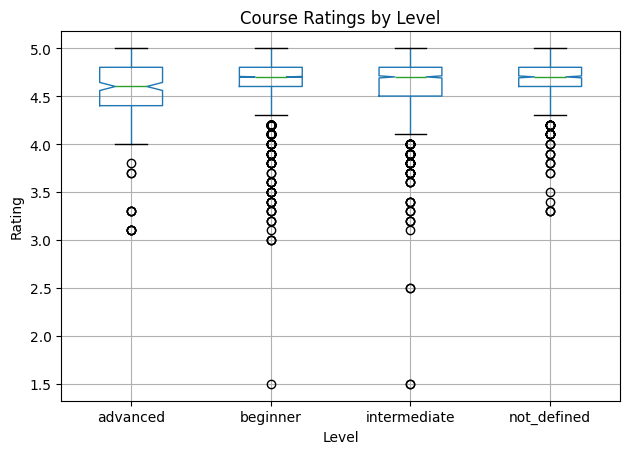

In [15]:
# drop columns with Ratings with values of 0.0, which is what I assigned to columns
# that didn't have rating, because it could mess up this analysis
unique_courses = unique_entries[unique_entries['Rating'] != 0.0]

plt.figure(figsize=(12, 8))
unique_courses.boxplot(column="Rating", by="Level", notch=True)
plt.title('Course Ratings by Level')
plt.suptitle('')  # Remove the automatic suptitle from pandas boxplot
plt.xlabel('Level')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()


# Analysis
I will use Numpy to be a able to perform some operations to get the values I want to find

## Courses Rating Average
Here I group same courses entries and calculate the average rating per course

In [16]:
# unique_courses = dataframe.groupby(['Level', 'Course Title','Instructor', 'Review', 'ammountOfHours']).size().reset_index(name="count")
# unique_courses = dataframe.drop_duplicates(subset=['Level', 'Course Title', 'Instructor', 'Rating', 'Review', 'ammountOfHours'])

# # unique_courses removes all courses that have the, Level
# review_variations = unique_courses.groupby(['Course Title', 'Instructor', 'ammountOfHours']).size().reset_index(name='count')

# review_variations.loc[review_variations['count'] > 1]

# len(review_variations)

# average_ratings = unique_courses.groupby(['Level', 'Course Title', 'Instructor', 'ammountOfHours'])['Rating'].mean().reset_index(name='Average Rating')

# agg_courses = dataframe.groupby(['Level', 'Course Title', 'Instructor', 'ammountOfHours']).agg({
#     'Rating': 'mean',
#     'Review': 'sum'  # or 'mean' if you'd rather average review counts too
# }).reset_index()

# len(average_ratings)


# unique_courses.loc[unique_courses['count'] == 9]

# unique_courses = dataframe.drop_duplicates(subset=['Level', 'Course Title', 'Instructor', 'Rating', 'Review', 'ammountOfHours'])



# unique_entries = dataframe.drop_duplicates()

# Rows with Rating 0 are the ones I transformed but in this analysis they might
# affect the result so I will remove them
filtered_entries = unique_entries[unique_entries['Rating'] != 0]

# Group same courses and get the average rating
average_ratings = filtered_entries.groupby(['Level', 'Course Title', 'Instructor', 'ammountOfHours'])['Rating'].mean().reset_index(name='average')

# group = average_ratings.loc[average_ratings['average'] < 2]

print('Muestra de los promedios de los ratings por curso:')
print('')
display(average_ratings.head())


Muestra de los promedios de los ratings por curso:



,Level,Course Title,Instructor,ammountOfHours,average
0,advanced,Manejo del enfermo semicrítico y crítico por ...,"['Josep Maria Nicolás Arfelis', 'Esther León C...",37.0,4.8
1,advanced,3-Axis Machining with Autodesk Fusion 360,[],27.0,4.9
2,advanced,3D Model Creation with Autodesk Fusion 360,[],14.0,4.8
3,advanced,AI Capstone Project with Deep Learning,"['Alex Aklson', 'Joseph Santarcangelo']",15.0,4.5
4,advanced,Active Optical Devices Specialization,['Juliet Gopinath'],43.3,4.1


## Highest and Lowest Ratings
We get the course with the highest rating average and the first course found that has the highest Rating entry and also do the same anallysis but to find the lowest rating average and rating entry

In [17]:
greatest_average = average_ratings['average'].max()
greatest_average_course = average_ratings.loc[average_ratings['average'].idxmax()]
print('')
print('')
print('El promedio mas alto es de:', greatest_average,', el primer curso encontrado con este promedio se llama:', greatest_average_course['Course Title'])

lowest_average = average_ratings['average'].min()
lowest_average_course = average_ratings.loc[average_ratings['average'].idxmin()]
print('El promedio mas bajo es de:', lowest_average,', el primer curso encontrado con este promedio se llama:', lowest_average_course['Course Title'])

greatest_rating = unique_entries['Rating'].max()
greatest_rating_course = unique_entries.loc[unique_entries['Rating'].idxmax()]
print('El Rating mas alto es de:', greatest_rating,', el primer curso encontrado con este Rating se llama:', greatest_rating_course['Course Title'])

lowest_rating = unique_entries['Rating'].min()
lowest_rating_course = unique_entries.loc[unique_entries['Rating'].idxmin()]
print('El Rating mas bajo es de:', lowest_rating,', el primer curso encontrado con este Rating se llama:', lowest_rating_course['Course Title'])


# A nice thing to do would be analize how many rows are we losing because the
# rating was missing, this may help us indicate a customer that there is a very
# bad issue in some place of our system, either the backed or frontend



El promedio mas alto es de: 5.0 , el primer curso encontrado con este promedio se llama: Back-end Application Development Capstone Project
El promedio mas bajo es de: 1.5 , el primer curso encontrado con este promedio se llama: Excel for Beginners: Beginner Functions
El Rating mas alto es de: 5.0 , el primer curso encontrado con este Rating se llama: Songwriting: Writing the Music
El Rating mas bajo es de: 0.0 , el primer curso encontrado con este Rating se llama: Distribución digital de la música independiente


## Flexible Courses Percentage
I calculate the percentage of courses that have a flexible schedule

In [18]:
flexible_courses = unique_entries[unique_entries['SchedFlexibility']]
print('La cantidad de cursos con horarios flexibles es de:', len(flexible_courses))

flexible_courses_percentage = (len(flexible_courses)*100)/len(unique_entries)
print('El porecntaje de cursos con horarios flexibles es de:', flexible_courses_percentage, '%')

La cantidad de cursos con horarios flexibles es de: 8054
El porecntaje de cursos con horarios flexibles es de: 92.6279470960322 %


# Natural LanguageProcessing Analyisis(NLP)






## Imports
The imports we need are the following:

* nltk: provides all the natural language analysis tools we need
* stopwords: used to remove words we don't need like very common words like: in, a, on, etc
* word_tokenize: helps us break a string into tokens
* WordNetLemmatizer: Helps lematize words. Lemmatization is linking similar meaning words as one word. The goal of lemmatization is to reduce a word to its root form, also called a lemma. For example, the verb running would be identified as run.
* SentimentIntensityAnalyzer: Return a float for sentiment strength based on the input text.
* Counter: Is a dict(key/value hash table) sublcass to for counting hashable objects

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

## Installations
* punkt: is an unsupervised trainable tokenizer that splits text into sentences. But this tools may have been deprecated
* punkt_tab: is the replacement for punkt
* stopwords: used to remove words we don't need like very common words like: in, a, on, etc
* WordNet: Is a lexical database of English. Using synsets, helps find conceptual relationships between words such as hypernyms, hyponyms, synonyms, antonyms etc
* vader_lexicon: is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.

In [20]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Upload Text File


In [21]:
reviews = files.upload()

Saving Coursera Comments.txt to Coursera Comments.txt


## Open File

In [22]:
with open('Coursera Comments.txt', 'r', encoding='utf-8') as file:
  text = file.read()

print('Preview del texto: ',text[:100])

Preview del texto:  
Abril Vargas Pérez
3 opiniones
PT
Valorada con 5 estrellas sobre 5
21 ago 2024
Escandalizada y conf


## Tokenization
I will split the text file into tokens and remove white spaces. Note that there is different characters we can remove like punctuation(`.`, `!`, `?`, `...`, etc), just plain white spaces and what you'd want to remove depends on how detail/naunced your sentiment analysis will be, below is a chart showing the preferable approach depending on the analysis model


| Model Type | Should You Remove Punctuation? | Why? |
| ---------- | ------------------------------ | ---- |
| Bag-of-Words / TF-IDF | ✅ Yes (usually) | Punctuation adds noise; models treat great! and great as different tokens |
| Rule-based Sentiment (e.g., VADER) | 	❌ No | Punctuation like !, ?, ... often conveys emphasis or emotion |
| Pretrained Transformers (e.g., BERT) | 	❌ No | Models handle punctuation intelligently during tokenization |


We intend to use `vader_lexicon` in our use case w rather use `token.isalpha()` ,which only returns True if all characters in the string are alphabetic letters (a-z, A-Z, no digits, no punctuation, no spaces) over, functions like `token.isspace()` because it only to remove white spaces but not punctuation

In [23]:
tokens = word_tokenize(text)
print("Tokens:", tokens[:10])
clean_tokens = [token.lower() for token in tokens if token.isalpha()]
print("Tokens limpios:", tokens[:10])

Tokens: ['Abril', 'Vargas', 'Pérez', '3', 'opiniones', 'PT', 'Valorada', 'con', '5', 'estrellas']
Tokens limpios: ['Abril', 'Vargas', 'Pérez', '3', 'opiniones', 'PT', 'Valorada', 'con', '5', 'estrellas']


## Remove Stopwords
I will use stopwords to finds words I don't need like common words as: 'in', 'a', 'an', 'han', 'o', 'u', etc

In [24]:
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))
print('Stop words:', stop_words)

Stop words: {'algunos', 'estaríais', 'tuyo', 'these', 'habremos', 'tengan', "wasn't", 'when', 'fueras', 'antes', 'here', 'estuviéramos', "it's", 'then', "isn't", 'during', 'we', 'what', 'but', 'tengo', 'why', 'yourself', 'same', 'in', 'needn', 'estuve', 'an', 'serás', 'she', 'tuvieron', 'so', "she's", 'very', 'sentidas', 'whom', 'ella', 'did', 'será', 'otros', 'ti', 'tienes', 'don', 'sentid', 'can', 'wasn', "we've", 'itself', "hasn't", 'tenidos', 'habido', 'd', 'soy', 'mías', 'ain', 'suyas', 'estabas', 'tu', 'a', 'ourselves', 'nuestras', 'estuvieron', 'nuestros', 'una', 'with', 'fuese', 'ya', 'this', 'qué', 'into', 'seréis', 'be', 'tenemos', 'couldn', 've', 'y', 'all', 'weren', 'los', 'estados', 'hayan', 'seamos', 'has', 'wouldn', 'estuvimos', 'quienes', 'tenéis', 'had', 'our', 'her', 'el', 'hay', 'suyo', "you're", 'ante', 'tuve', 'quien', 'tendríamos', 'estada', 'seríamos', 'tuvieses', "should've", "i'm", 'tenga', 'teniendo', 'sois', 'desde', 'hubieron', 'vosotras', 'más', 'vuestra', 

## Filter Tokens

In [25]:
filtered_tokens = [token for token in clean_tokens if token not in stop_words]
print('Tokens filtrados:', filtered_tokens[:100])

Tokens filtrados: ['abril', 'vargas', 'pérez', 'opiniones', 'pt', 'valorada', 'estrellas', 'ago', 'escandalizada', 'confundida', 'escandalizada', 'confundida', 'malas', 'reseñas', 'coursera', 'mes', 'julio', 'haciendo', 'actualmente', 'curso', 'developer', 'imparte', 'meta', 'entrar', 'curso', 'pagar', 'coursera', 'plus', 'acceso', 'cursos', 'euros', 'mensuales', 'duré', 'periodo', 'prueba', 'gratis', 'días', 'hicieron', 'cargo', 'llevo', 'casi', 'dos', 'meses', 'haciendo', 'curso', 'dado', 'ningún', 'tipo', 'problemas', 'súper', 'completo', 'mayor', 'problemas', 'abrir', 'cada', 'modulo', 'quizás', 'unica', 'pega', 'asesores', 'personales', 'foros', 'discusión', 'bastante', 'receptivos', 'alumnos', 'ayudan', 'creo', 'gente', 'malas', 'experiencias', 'saben', 'leer', 'detenimiento', 'letras', 'pequeñas', 'cursos', 'gratis', 'luego', 'pagos', 'caso', 'leí', 'detenimiento', 'toda', 'información', 'transparencia', 'tema', 'pagos', 'fin', 'recomiendo', 'coursera', 'certificados', 'muchas',

## Lemmatization
The goal of lemmatization is to reduce a word to its root form, also called a lemma. For example, the verb running would be identified as run.

In [26]:
lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
print("Tokens lemmatizados:", lemmatized_tokens[:100])

Tokens lemmatizados: ['abril', 'vargas', 'pérez', 'opiniones', 'pt', 'valorada', 'estrellas', 'ago', 'escandalizada', 'confundida', 'escandalizada', 'confundida', 'malas', 'reseñas', 'coursera', 'me', 'julio', 'haciendo', 'actualmente', 'curso', 'developer', 'imparte', 'meta', 'entrar', 'curso', 'pagar', 'coursera', 'plus', 'acceso', 'cursos', 'euro', 'mensuales', 'duré', 'periodo', 'prueba', 'gratis', 'días', 'hicieron', 'cargo', 'llevo', 'casi', 'do', 'meses', 'haciendo', 'curso', 'dado', 'ningún', 'tipo', 'problemas', 'súper', 'completo', 'mayor', 'problemas', 'abrir', 'cada', 'modulo', 'quizás', 'unica', 'pega', 'asesores', 'personales', 'foros', 'discusión', 'bastante', 'receptivos', 'alumnos', 'ayudan', 'creo', 'gente', 'malas', 'experiencias', 'saben', 'leer', 'detenimiento', 'letras', 'pequeñas', 'cursos', 'gratis', 'luego', 'pagos', 'caso', 'leí', 'detenimiento', 'toda', 'información', 'transparencia', 'tema', 'pagos', 'fin', 'recomiendo', 'coursera', 'certificados', 'muchas',

## Words Frequency

Frecuencia de tokens: [('semana', 1641)]


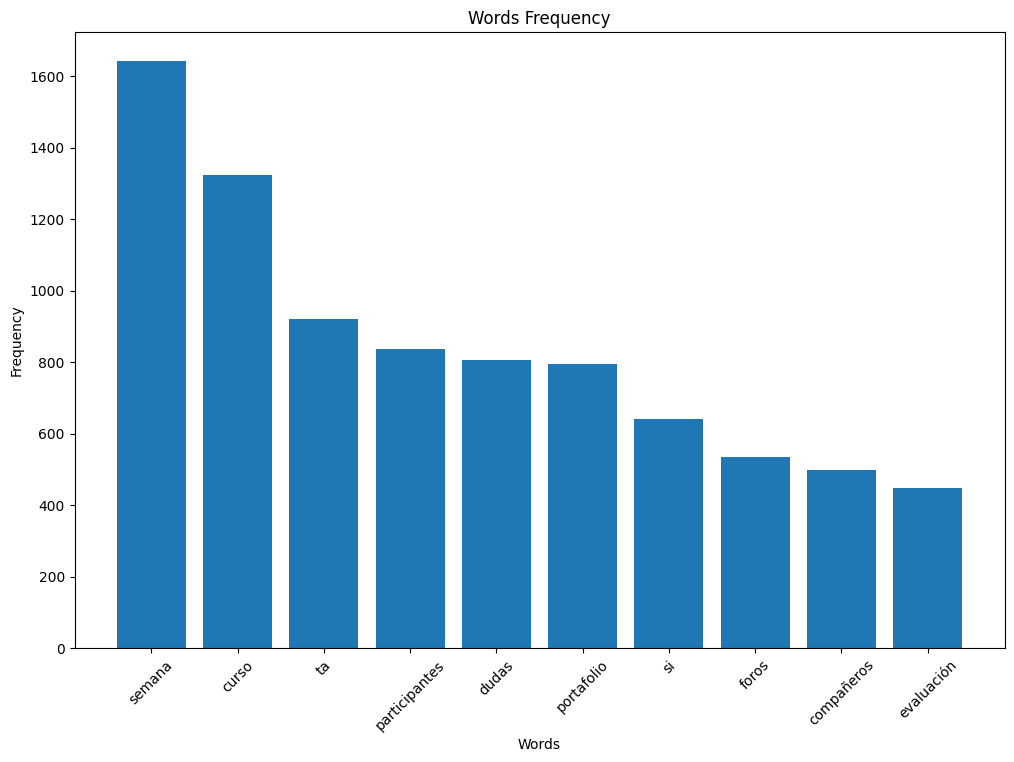

In [27]:
frequency = Counter(lemmatized_tokens)
print("Frecuencia de tokens:", frequency.most_common(1))

words_frequency = frequency.most_common(10)
words = [word for word, count in words_frequency]
counts = [count for word, count in words_frequency]

plt.figure(figsize=(12,8))
plt.bar(words, counts)
plt.title("Words Frequency")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

## Sentiment Analysis

In [28]:
SIA = SentimentIntensityAnalyzer()
sentiments = SIA.polarity_scores(text)
print('Los sentimientos son:', sentiments)

Los sentimientos son: {'neg': 0.035, 'neu': 0.954, 'pos': 0.011, 'compound': -1.0}


## Sentiment Analysis Vizualization

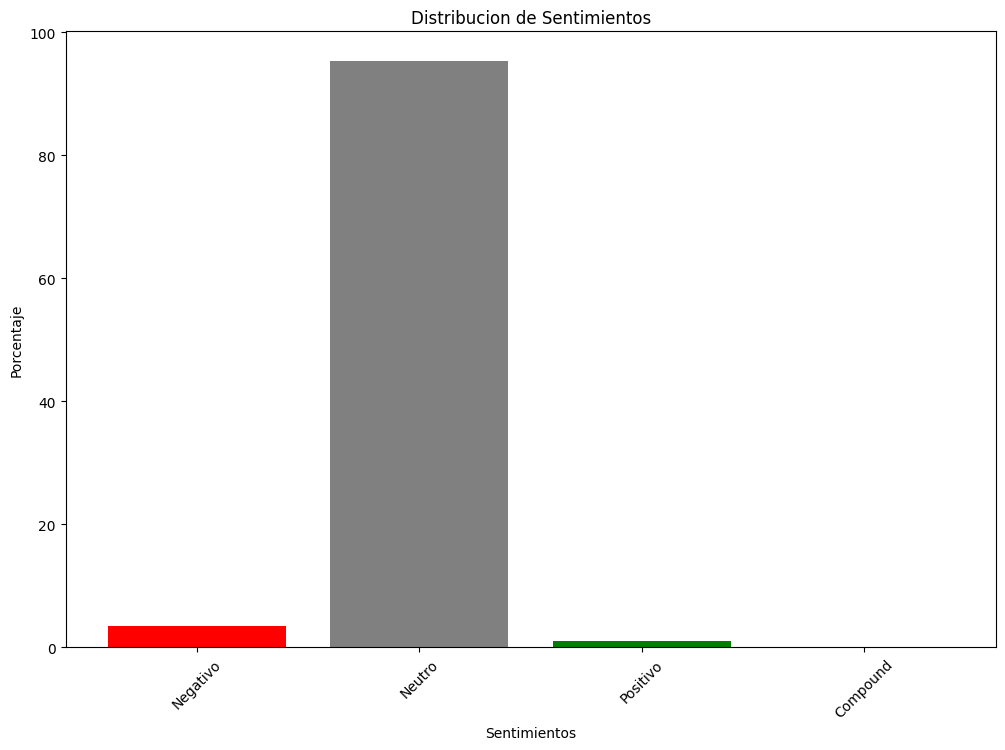

In [29]:
# Multiply all values by 100 to get the percentage
scaled = {k: v * 100 for k, v in sentiments.items()}

# Replace negative values with 0
adjusted = {k: v if v >= 0 else 0 for k, v in scaled.items()}

labels = ['Negativo', 'Neutro', 'Positivo', 'Compound']
sizes = [adjusted['neg'], adjusted['neu'], adjusted['pos'], adjusted['compound']]
colors = ['red', 'gray', 'green', 'yellow']
plt.figure(figsize=(12,8))
plt.bar(labels, sizes, color=colors)
plt.xlabel("Sentimientos")
plt.ylabel("Porcentaje")
plt.xticks(rotation=45)
plt.title('Distribucion de Sentimientos')
plt.show()

# Natural Entity Recognition(NER)
This analysis can help us identify popular people, organizations, locations or words, basically identify trends

## Imports
* spacy: natural language processing library to process text and extract named entities. The code iterates through the named entities identified in the processed document and printing each entity’s text, start character, end character and label.

In [30]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# from transformers import pipeline

In [31]:
!pip install -U spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 88.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [32]:
import spacy

## NER using Spacy
I will use the model/pipeline called `es_core_news_sm`. A pipeline in SpaCy can be seen as a series of processes that include tokenization, lemmatization and several other processes to be able to identify and clasify lemmas

In [33]:
nlp = spacy.load("es_core_news_sm")

# Read the text file
with open('Coursera Comments.txt', 'r', encoding='utf-8') as file:
    text = file.read()

nlp.max_length = 1147900

# Process the text with spaCy
doc = nlp(text)

entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]


## Prepare Info for Visualization
We create a dataframe to be able to create a vizualization

In [34]:
df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])

df.head()

,text,type,lemma
0,Vargas Pérez,PER,Vargas Pérez
1,PT\nValorada,MISC,PT\nValorada
2,Escandalizada,LOC,Escandalizada
3,Escandalizada,PER,Escandalizada
4,Estoy en coursera,MISC,estar en coursera


## NER Analysis
Lets see different metrics the following metrics:
* Category with the highest quantity of lemas
* The 5 most popular lemmas in each category

## Visualization

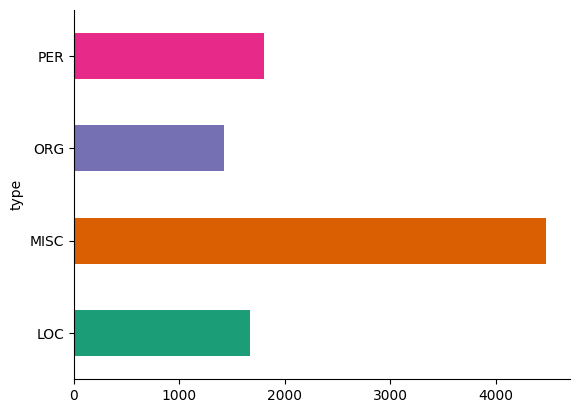

In [35]:
# @title type

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Lemmas Top 5 Per Category

In [36]:
grouped_lemmas = df.groupby(['type', 'lemma']).size().reset_index(name='frequency')

# gropued_lemas = grouped_lemmas.sort_values(by=['type', 'frequency'], ascending=False)

location = grouped_lemmas.loc[grouped_lemmas['type'] == 'LOC'].sort_values(by=['type', 'frequency'], ascending=False).head()
miscellanious = grouped_lemmas.loc[grouped_lemmas['type'] == 'MISC'].sort_values(by=['type', 'frequency'], ascending=False).head()
organization = grouped_lemmas.loc[grouped_lemmas['type'] == 'ORG'].sort_values(by=['type', 'frequency'], ascending=False).head()
persons = grouped_lemmas.loc[grouped_lemmas['type'] == 'PER'].sort_values(by=['type', 'frequency'], ascending=False).head()

print('lemmas de localidades mas mencionados:\n', location)

print('\nlemmas de miscelanios mas mencionados:\n', miscellanious)

print('\nlemmas de organizaciones mas mencionados:\n', organization)

print('\nlemmas de personas mas mencionadas:\n', persons)


lemmas de localidades mas mencionados:
     type            lemma  frequency
97   LOC         Búsqueda        211
806  LOC                ¿         49
151  LOC         Coursera         40
452  LOC  Sandoval Flores         28
334  LOC  María Guadalupe         23

lemmas de miscelanios mas mencionados:
       type        lemma  frequency
1583  MISC     Semana 1        239
1584  MISC     Semana 2        202
1587  MISC     Semana 4        184
1707  MISC  Visibilidad        180
1586  MISC     Semana 3        170

lemmas de organizaciones mas mencionados:
      type       lemma  frequency
3203  ORG          TA        383
3157  ORG         REA        129
3104  ORG     Miembro         27
3048  ORG      Google         16
3138  ORG  PORTAFOLIO         14

lemmas de personas mas mencionadas:
      type               lemma  frequency
4425  PER             también         86
3572  PER  Alejandro González         24
4202  PER              además         23
4268  PER                duda         22
35

# Conlusions
* Vizualizations helps us to understand data with ease saving us time and allowing us to communicate with stakeholders, partners and other non technical people
* We have various plot types we can choose from depending from the metric we want to meassure or analyze
* We can use tools like Matplotlib in Python to generate plots
* Mathematical/arithmetical calculations are possible to do very easily with tools like Numpy
* Getting data like averages, max and min values help us understand popular topics or trends but also improvement areas
* NLP(Natural Language Processing) is a process that involves tokenization(separating text into words), lemmatization(reducing words to its root form called lemmas, like running to run), and sentiment analysis to understand how the users feel about a product or service
* Natural Entity Recognition(NER) is a process that helps us identify trends by generating lemma types defined by a tool, in this case I used SpaCy which recognized lemmas of "Location", "Person", "Organization" and "Miscellanious" Types, as you can see this enables us to identify popular locations, persons, organizations and other info.